# Text exploration

Here we explore the text data we have so far. We want to see what sort of analyses are possible.

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
from utils import multicore_apply

from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

pd.set_option('display.max_columns', None)

## Load the data

In [2]:
with open('../data/maori_newspapers.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [3]:
papers

,url,text
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi..."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te..."
2,https://paperspast.natlib.govt.nz/newspapers/A...,KI WGA MAORI : '• ■ ‘ ■ ■ - ■ ■ ; 1 SVgil c.la...
3,https://paperspast.natlib.govt.nz/newspapers/A...,HE MEA TUKU MAI E NGA WHARE ERUA O TE PAREMATA...
4,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...
...,...,...
29371,https://paperspast.natlib.govt.nz/newspapers/W...,"TE WAKA MAORI O AHURIRI.\n""KO TE TIKA, KO TE P..."
29372,https://paperspast.natlib.govt.nz/newspapers/W...,TARANAKI.\nKUA HINGA TE PAREKURA. EKUA TE KAU ...
29373,https://paperspast.natlib.govt.nz/newspapers/W...,Eta ma. Kia rongo koutou. Ko tenei nupepa tuat...
29374,https://paperspast.natlib.govt.nz/newspapers/W...,"Me Hoturoa o mua i te i tona waka, a Tainui, k..."


In [4]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11
2,https://paperspast.natlib.govt.nz/newspapers/A...,KI WGA MAORI : '• ■ ‘ ■ ■ - ■ ■ ; 1 SVgil c.la...,AONUPEP,1892,06,04,2.14.1
3,https://paperspast.natlib.govt.nz/newspapers/A...,HE MEA TUKU MAI E NGA WHARE ERUA O TE PAREMATA...,AONUPEP,1892,06,04,2.13
4,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1


In [42]:
len(papers[['newspaper_id', 'year', 'month', 'day']].drop_duplicates())

1566

In [36]:
len(papers.url.unique())

28259

In [30]:
papers.year.value_counts().sort_index().to_frame().reset_index().to_csv('articles_per_year.csv')

In [6]:
print(len(papers.newspaper_id.unique()))

21


In [7]:
papers.newspaper_id.value_counts()

MMTKM      5448
WAKAM      5343
WANANG     4226
KORIM      3394
MATUH      2587
PUKEH      2269
JUBIL      2193
HUIA        997
KOP         818
MKURA       798
AMW         475
HAEATA      357
PAKIOM      199
WHETU        66
KAHITI       56
HOKIOI       51
TAKIT        31
AONUPEP      23
PIHOI        22
MATAR        20
HIIR          3
Name: newspaper_id, dtype: int64

In [8]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [9]:
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 94.3k/94.3k [00:01<00:00, 60.7kit/s] 
94346it [00:00, 520567.04it/s]


,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","WANTKD, a smart LAD, ' and n rite."
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","Apply ai Zi alamli'i"" Office."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","""Na te Tika i toa ai."""
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","Turei, Huri 17, 1848."


In [11]:
papers['clean_sentence'] = (papers
    .sentence
    .str.replace("[\-—]+", " ")
    .str.replace("[^\w\s]+", "")
    .str.lower()
)

<AxesSubplot:ylabel='Frequency'>

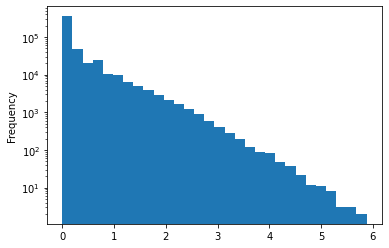

In [28]:
np.log10(pd.Series([w for s in papers['clean_sentence'] for w in s.split()]).value_counts()).plot(kind = 'hist', bins = 30, logy = True)

In [13]:
papers['num_words'] = papers.clean_sentence.apply(lambda x: len(x.split()))

<AxesSubplot:ylabel='newspaper_id'>

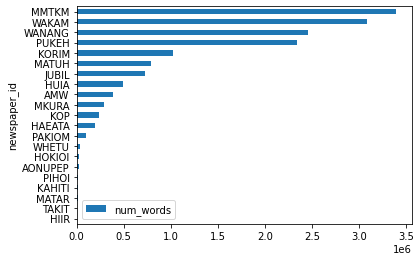

In [14]:
papers.groupby('newspaper_id').agg({'num_words': np.sum}).sort_values('num_words').plot(kind = 'barh')

In [15]:
newspaper_corpus = papers.groupby('newspaper_id').agg({'clean_sentence': lambda s: ' '.join(s)}).clean_sentence

In [21]:
tfidf = TfidfVectorizer(stop_words = 'english', min_df = 3, max_df = 0.9, ngram_range = (1,4))

In [22]:
%%time
X = tfidf.fit_transform(newspaper_corpus)

CPU times: user 55.2 s, sys: 1.74 s, total: 56.9 s
Wall time: 56.9 s


In [23]:
X

<21x588366 sparse matrix of type '<class 'numpy.float64'>'
	with 2740979 stored elements in Compressed Sparse Row format>

In [24]:
print(tfidf.get_feature_names()[:10])

['00', '00 10', '00 ka', '00 ko', '00 ko nga', '000', '000 000', '000 ko', '000 mano', '000 nga']


## Show the top 10 words by TFIDF

In [25]:
def get_top_tf_idf_words(response, top_n=2):
    feature_names = np.array(tfidf.get_feature_names())
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

top_tfidf = (pd.DataFrame(
    dict(zip(
        newspaper_corpus.index, 
        [get_top_tf_idf_words(response, 10) for response in X])))
    .transpose()
)
top_tfidf

,0,1,2,3,4,5,6,7,8,9
AMW,new,tbe,said,mr,government,time,great,land,shall,zealand
AONUPEP,kawanatanga,paremata,kooti,whenua maori,te paremata,te kawanatanga,te iwi maori,komihana,te kooti,tiriti
HAEATA,ki le,kahore,ole,alua,ralou,tangaia,hahi,lenei,tapu,te atua
HIIR,kaunihera,kaunihora,te kaunihera,tuuru ka,tiamana,mema,nga mema,kohi,te whitu,hekeretari
HOKIOI,hau,kingi,ka mea,kawana,unknown,te rori,ngati,kahuri,li,1863
HUIA,mema,mote,kote,huia,pire,pooti,kawanatanga,paremata,etita,pepa
JUBIL,tiupiri,te tiupiri,whanganui,onga,pire,etita,mema,komiti,kote,pepa
KAHITI,kooti,whakawa whenua,whenua maori,whakawa whenua maori,maungakawa,kooti whakawa,kooti whakawa whenua,kiingitanga,maungatautari,panuitanga
KOP,hereni,poneke,hoiho,karere,pene mo,1858,pene mo te,mo te pauna,pene,pene mo te pauna
KORIM,te korimako,korimako,akarana,kahore,tekau,pea,kuini,iari,notemea,ki te mo te
